In [93]:
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

#in practice do not supress these warnings, they carry important information about the status of your model
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Simulate Buying and Selling Stock Using ARMA(p,q)

In [94]:
def run_simulation(returns, prices, amt, order, thresh, verbose=False, plot=True):
    if type(order) == float:
        thresh = None
        
    curr_holding = False
    events_list = []
    init_amt = amt

    #go through dates
    for date, r in tqdm (returns.iloc[14:].items(), total=len(returns.iloc[14:])):
        #if you're currently holding the stock, sell it
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding=False
            ret = (sell_price-buy_price)/buy_price
            amt *= (1+ret)
            events_list.append(('s', date, ret))
            
            if verbose:
                print('Sold at $%s'%sell_price)
                print('Predicted Return: %s'%round(pred,4))
                print('Actual Return: %s'%(round(ret, 4)))
                print('=======================================')
            continue

        #get data til just before current date
        curr_data = returns[:date]
        
        if type(order) == tuple:
            try:
                #fit model
                model = ARIMA(curr_data, order=order).fit()

                #get forecast
                pred = model.forecast()[0][0]

            except:
                pred = thresh - 1



        #if you predict a high enough return and not holding, buy stock
        if (not curr_holding) and \
        ((type(order) == float and np.random.random() < order) 
         or (type(order) == tuple and pred > thresh)
         or (order == 'last' and curr_data[-1] > 0)):
            
            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s'%buy_price)
                
    if verbose:
        print('Total Amount: $%s'%round(amt,2))
        
    #graph
    if plot:
    
        plt.figure(figsize=(10,4))
        plt.plot(prices[14:])

        y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
        shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims), 
                                  event[1], events_list[idx-1][1], color=color, alpha=0.1)

        tot_return = round(100*(amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("%s Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s"%(tickerSymbol, thresh, round(amt,2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()
    
    return amt

# Read Data

In [95]:
tickerSymbol = 'AAPL'
data = yf.Ticker(tickerSymbol)

In [96]:
prices = data.history(start='2021-01-01', end='2021-04-01').Close
#prices=stock_data['Close']
returns = prices.pct_change().dropna()
prices

Date
2021-01-04 00:00:00-05:00    127.680000
2021-01-05 00:00:00-05:00    129.258606
2021-01-06 00:00:00-05:00    124.907562
2021-01-07 00:00:00-05:00    129.169815
2021-01-08 00:00:00-05:00    130.284729
                                ...    
2021-03-25 00:00:00-04:00    119.155693
2021-03-26 00:00:00-04:00    119.768326
2021-03-29 00:00:00-04:00    119.946190
2021-03-30 00:00:00-04:00    118.473915
2021-03-31 00:00:00-04:00    120.697151
Name: Close, Length: 61, dtype: float64

Text(0, 0.5, 'Prices')

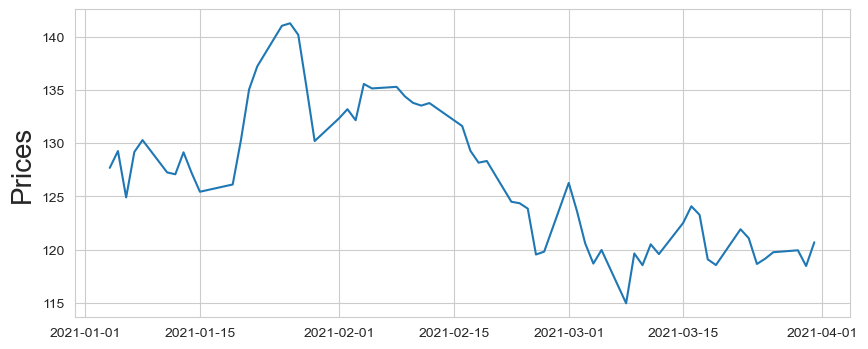

In [97]:
plt.figure(figsize=(10,4))
plt.plot(prices)
plt.ylabel('Prices', fontsize=20)

Text(0, 0.5, 'Return')

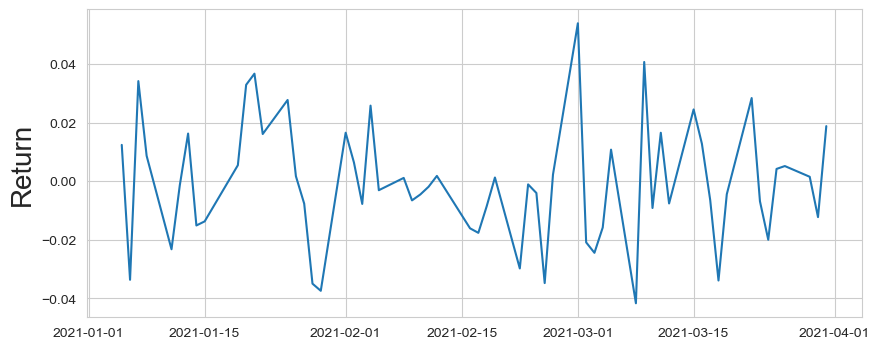

In [98]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Return', fontsize=20)

Returns just means what is the percent change in stock price between one day in the next. So sometimes it's less than zero. Those are days where the stock price is going down and sometimes it's greater thicker than zero where the stock price is going up.

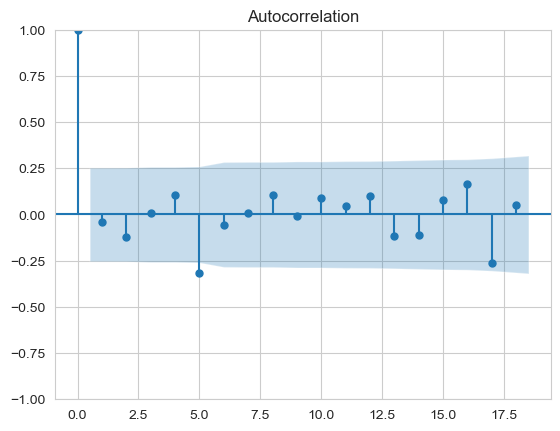

In [99]:
plot_acf(returns)
plt.show()

/Users/yujiewang/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


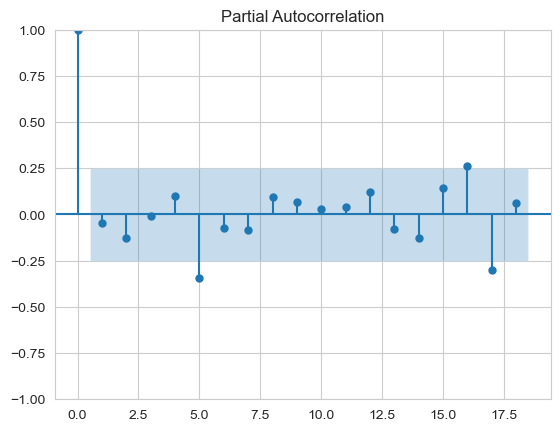

In [100]:
plot_pacf(returns)
plt.show()

# Baseline Model : Random Buying

What it's really doing is just random buying so here's a graphic of what it does.

Basically every day it randomly chooses whether or not to buy the stock and then on the subsequent day, it's just going to sell the stock no matter if it's hot high or low.

Basically these red windows are places where it bought the stock at the left of the window and the stock price went down where it sold the stock on the following day.

The green windows are aware it bought the stock and then this stock price actually went up.

100%|██████████| 46/46 [00:00<00:00, 9774.95it/s]


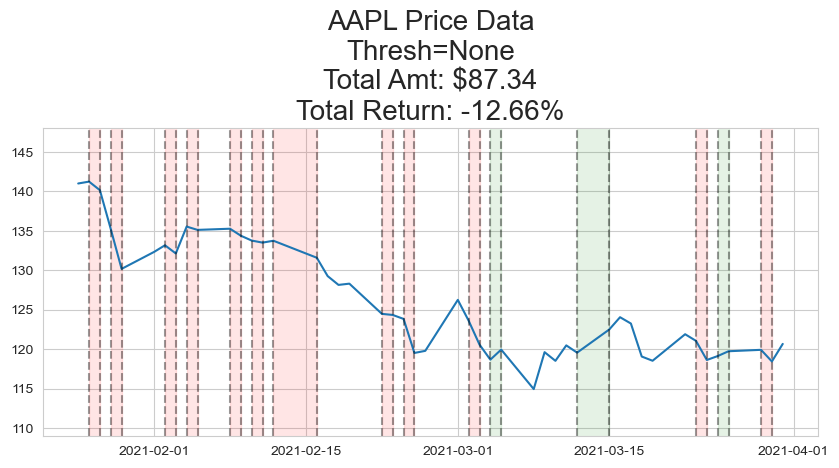

87.33962588967809

In [101]:
run_simulation(returns, prices, 100, 0.5, None, verbose=False)

In [102]:
final_amts = [run_simulation(returns, prices, 100, 0.5, None, verbose=False, plot=False) for _ in range(1000)]

100%|██████████| 46/46 [00:00<00:00, 37521.97it/s]


/var/folders/vp/8_rd4_c56g3dpqb1167z6tqr0000gn/T/ipykernel_27329/3379417299.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(final_amts)


Text(0.5, 1.0, 'Avg: $94.64\nSD: $6.4')

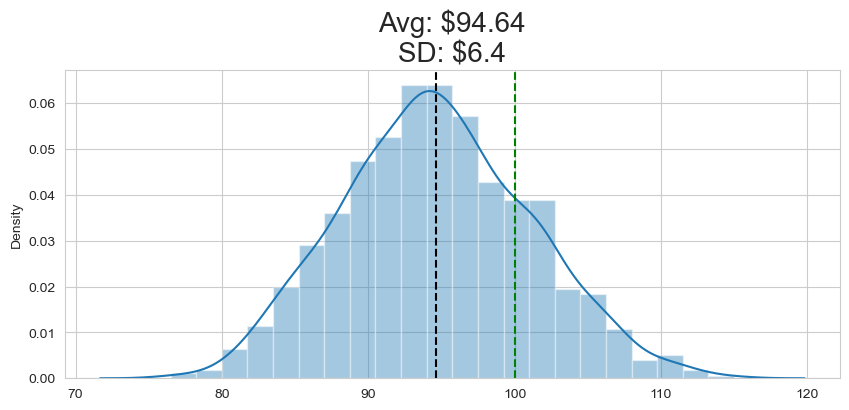

In [103]:
plt.figure(figsize=(10,4))
sns.distplot(final_amts)
plt.axvline(np.mean(final_amts), color='k', linestyle='--')
plt.axvline(100, color='g', linestyle='--')
plt.title('Avg: $%s\nSD: $%s'%(round(np.mean(final_amts),2), round(np.std(final_amts),2)), fontsize=20)

There is a histogram of the total amount of money you have at the end after a random buying scheme.

The dash line is how much you started with and this histogram shows how much you end with

# If Last Return was Positive, Buy

Let's do one more baseline method, this method says if the last return was positive then you're going to buy the stock and then immediately sell it on the day after that.

100%|██████████| 46/46 [00:00<00:00, 32285.47it/s]


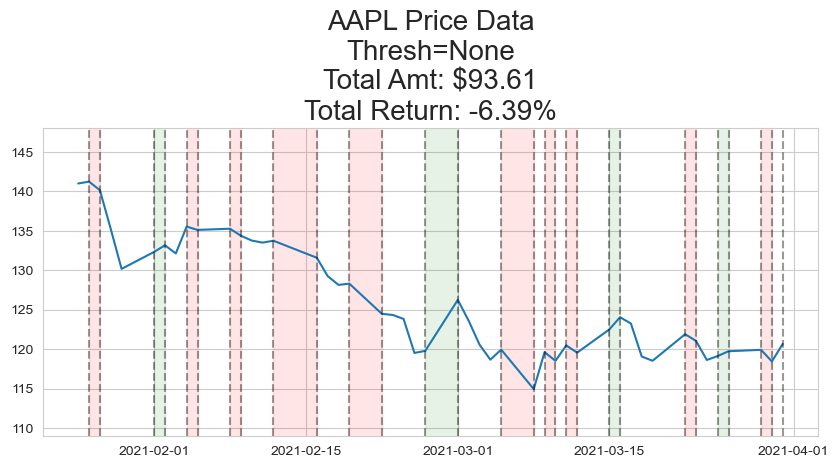

93.60995527969787

In [104]:
run_simulation(returns, prices, 100, 'last', None, verbose=False)

For example, take a look at this little green window here right before that the stock price is going up, so you say that it's going up. Let me buy it and then after that you sell it one day after, so the green winding windows are again where you made a good decision and the stock price continued to go up sfter that and the red windows are where you made a bad decision where all the way was going up the previous day when you bought it. It went down after that.

We're actually doing worse than before

# Try AR(1) Model

Run different AR1 models, they're different based on the threshold

What we do is we forecast what the stock return will be on the following day. We forecast that using AR1 model. If that predicted return is bigger than some threshold so you're going to buy the stock on the next day. And you're going to immediately sell the stock on the following day.

100%|██████████| 46/46 [00:00<00:00, 84.75it/s]


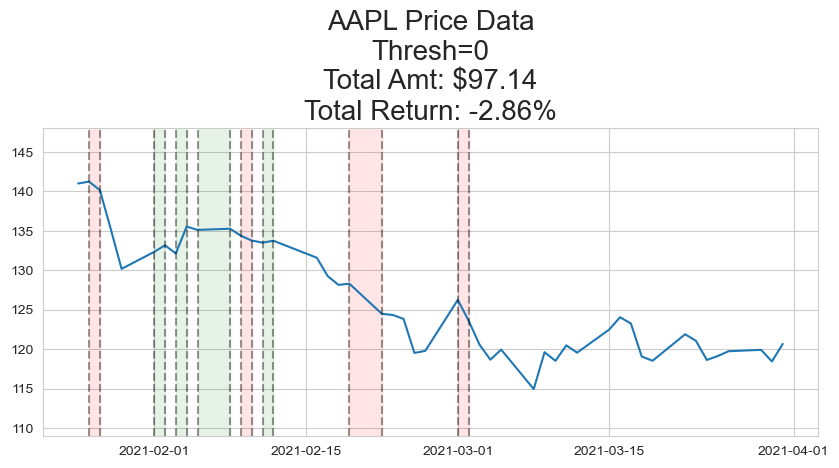

100%|██████████| 46/46 [00:00<00:00, 93.31it/s]


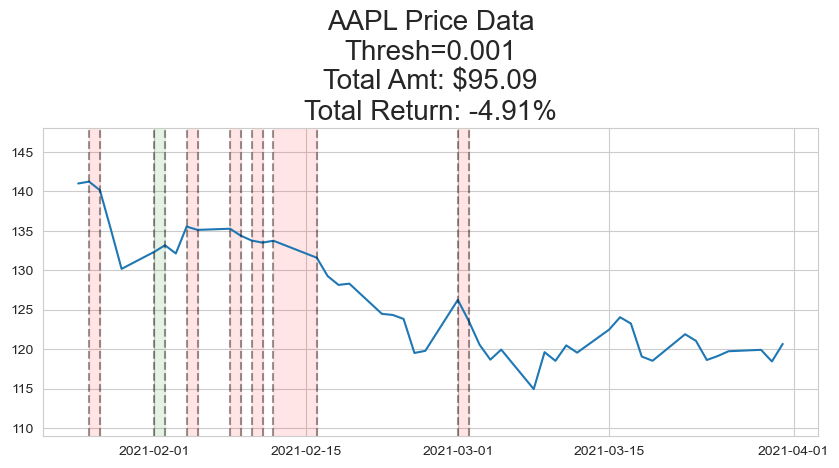

100%|██████████| 46/46 [00:00<00:00, 84.30it/s]


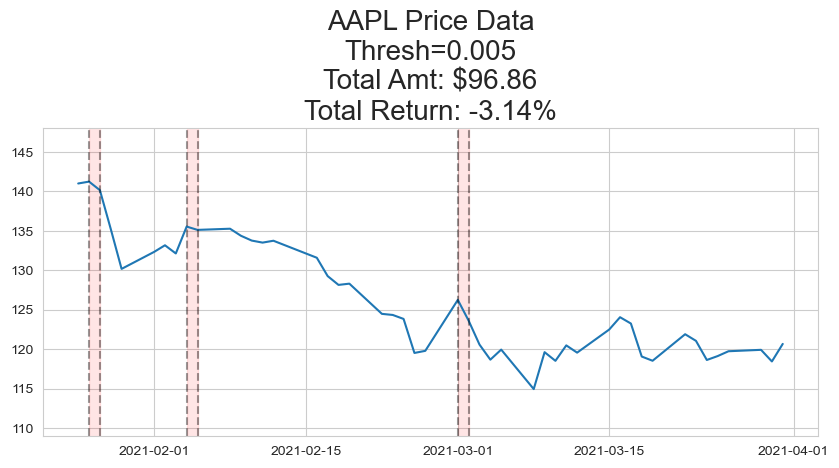

In [105]:
def run_simulation(returns, prices, amt, order, thresh, verbose=False, plot=True):
    if type(order) == float:
        thresh = None
        
    curr_holding = False
    events_list = []
    init_amt = amt

    #go through dates
    for date, r in tqdm (returns.iloc[14:].items(), total=len(returns.iloc[14:])):
        #if you're currently holding the stock, sell it
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding=False
            ret = (sell_price-buy_price)/buy_price
            amt *= (1+ret)
            events_list.append(('s', date, ret))
            
            if verbose:
                print('Sold at $%s'%sell_price)
                print('Predicted Return: %s'%round(pred,4))
                print('Actual Return: %s'%(round(ret, 4)))
                print('=======================================')
            continue

        #get data til just before current date
        curr_data = returns[:date]
        
        if type(order) == tuple:
            try:
                #fit model
                model = ARIMA(curr_data, order=order).fit()

                #get forecast
                pred = model.forecast().values[0]
                
            except:
                pred = thresh - 1



        #if you predict a high enough return and not holding, buy stock
        if (not curr_holding) and \
        ((type(order) == float and np.random.random() < order) 
         or (type(order) == tuple and pred > thresh)
         or (order == 'last' and curr_data[-1] > 0)):
            
            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s'%buy_price)
                
    if verbose:
        print('Total Amount: $%s'%round(amt,2))
        
    #graph
    if plot:
    
        plt.figure(figsize=(10,4))
        plt.plot(prices[14:])

        y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
        shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims), 
                                  event[1], events_list[idx-1][1], color=color, alpha=0.1)

        tot_return = round(100*(amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("%s Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s"%(tickerSymbol, thresh, round(amt,2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()
    
    return amt

for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (1,0,0), thresh, verbose=False)

# Try AR(5) Model

  4%|▍         | 2/46 [00:00<00:02, 18.90it/s]/Users/yujiewang/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yujiewang/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
100%|██████████| 46/46 [00:02<00:00, 21.55it/s]


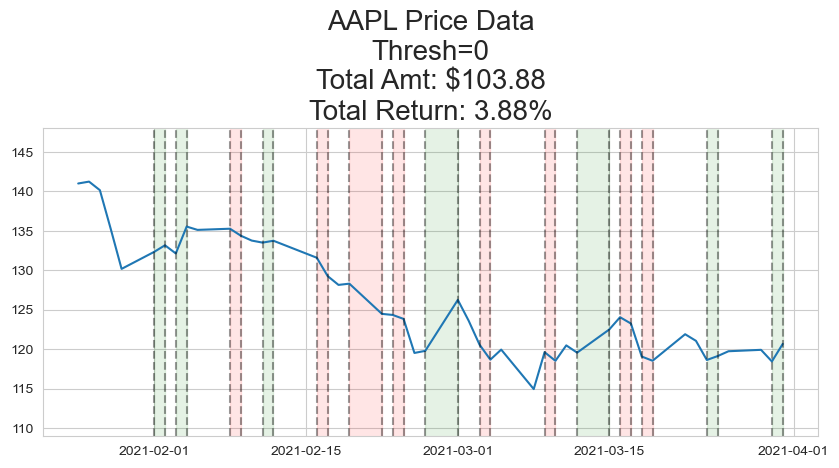

  4%|▍         | 2/46 [00:00<00:02, 18.06it/s]/Users/yujiewang/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yujiewang/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
100%|██████████| 46/46 [00:01<00:00, 25.00it/s]


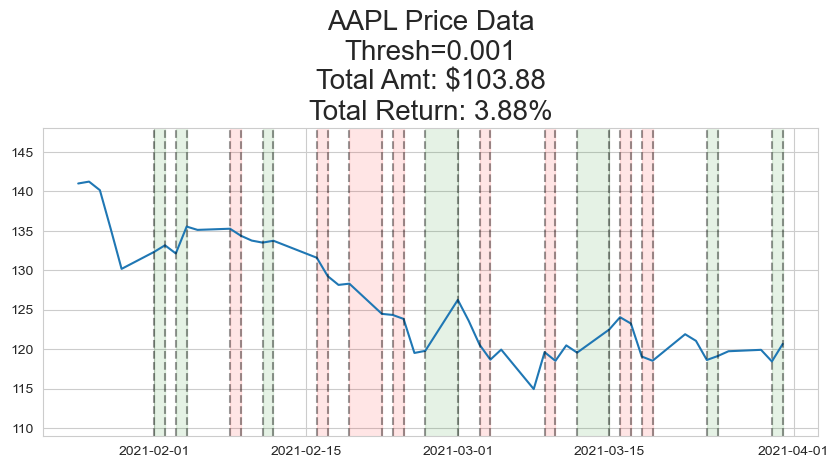

  4%|▍         | 2/46 [00:00<00:02, 17.62it/s]/Users/yujiewang/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yujiewang/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
100%|██████████| 46/46 [00:02<00:00, 20.84it/s]


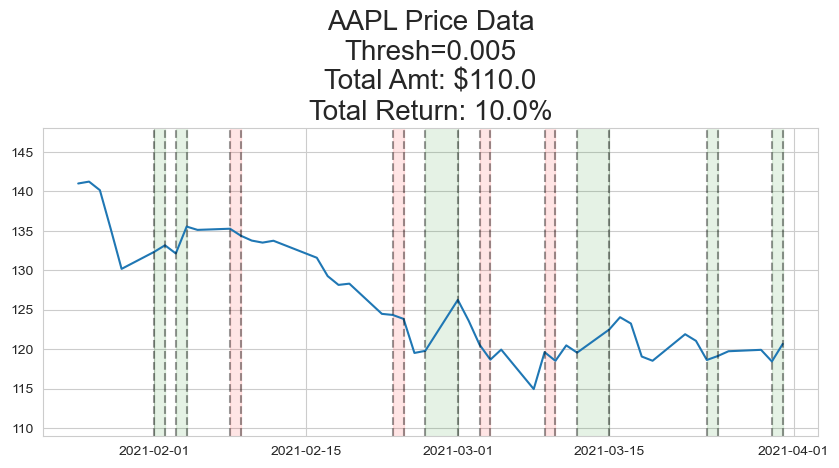

In [106]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (5,0,0), thresh, verbose=False)

# Try ARMA(5,5) Model

  0%|          | 0/46 [00:00<?, ?it/s]/Users/yujiewang/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
  4%|▍         | 2/46 [00:00<00:06,  6.47it/s]/Users/yujiewang/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Users/yujiewang/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/yujiewang/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting 

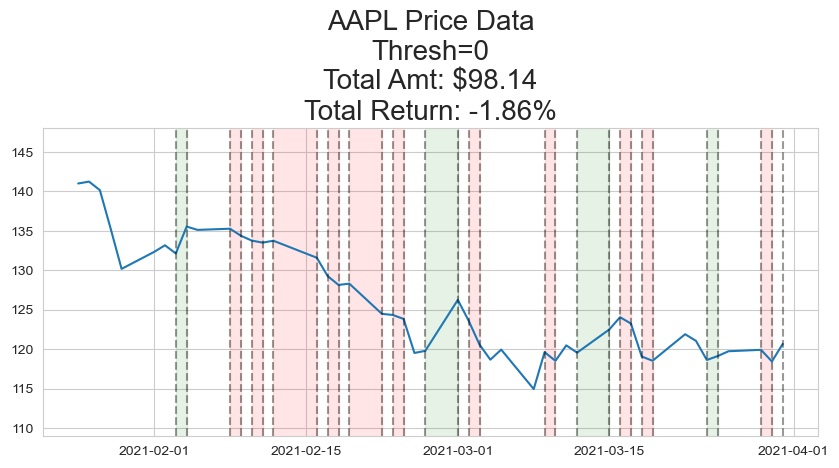

  0%|          | 0/46 [00:00<?, ?it/s]/Users/yujiewang/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
  4%|▍         | 2/46 [00:00<00:04,  9.01it/s]/Users/yujiewang/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Users/yujiewang/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/yujiewang/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting 

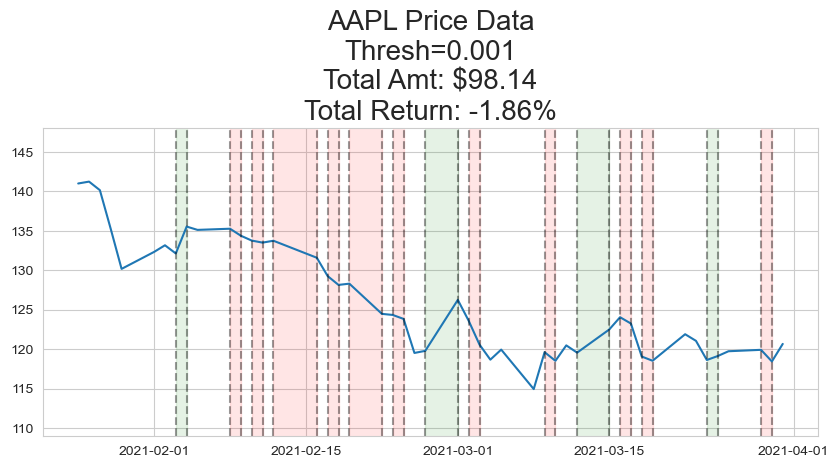

  0%|          | 0/46 [00:00<?, ?it/s]/Users/yujiewang/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
  2%|▏         | 1/46 [00:00<00:04,  9.45it/s]/Users/yujiewang/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Users/yujiewang/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/yujiewang/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting 

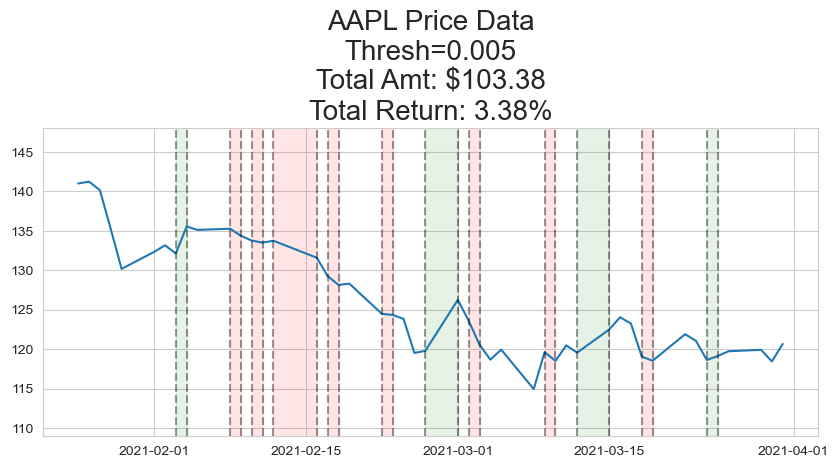

In [107]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (5,0,5), thresh, verbose=False)